Import all required libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
import os
import itertools

os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.style.use('seaborn')
pd.options.display.max_rows = 4000
%matplotlib inline
pd.set_option('display.max_columns', 100)

## Import Data from Data.World

In [2]:
df_data1 = pd.read_csv('1976_to_2015_Draftees_edit2.csv',index_col=0)

In [5]:
# Dropping columns we dont need for merge
df_data1.drop(columns=['All_NBA','All.Star','Yrs','Games','Minutes.Played','PTS', 'TRB', 'AST', 'FG_Percentage',
       'TP_Percentage', 'FT_Percentage', 'Minutes.per.Game', 'Points.per.Game',
       'TRB.per.game', 'Assits.per.Game', 'Win.Share', 'WS_per_game', 'BPM',
       'VORP', 'Executive', 'Tenure', 'Exec_ID', 'Exec_draft_exp','first_year', 'second_year', 'third_year',
       'fourth_year', 'fifth_year'],inplace = True)

In [6]:
# Column must be renamed in order to merge the two data sets
df_data1 = df_data1.rename(columns={'Player':'Name'})

In [8]:
# Imported 2nd data frame that had our target variable
df_data2 = pd.read_csv('nba_logreg.csv')

In [10]:
# Some name repeated twice so dropped duplicates
df_data2.drop_duplicates(subset ='Name', keep = False, inplace = True)

## Merged Data Frame

In [11]:
# Merged data frames by name and used an inner join
df = df_data2.merge(df_data1, on='Name', how='inner')

In [13]:
df.shape

(1088, 26)

In [14]:
# Some duplicated carried over again so dropped them again
df.drop_duplicates(subset ='Name', keep = False, inplace = True)

In [15]:
df.shape

(1058, 26)

## Data Cleaning and Feature Engineering

In [17]:
# Created a dictionary to replace all power 5 teams with a 1
conf_dict = {'University of Kentucky':1,'Duke University':1,'University of North Carolina':1,'University of California, Los Angeles':1,
'University of Arizona':1,'University of Kansas':1,'Syracuse University':1,'Georgia Institute of Technology':1,
'University of Louisville':1,'University of Michigan':1,'University of Notre Dame':1,'Ohio State University':1,
'North Carolina State University':1,'University of Alabama':1,'Michigan State University':1,'University of Arkansas':1,
'University of Maryland':1,'Indiana University':1,'Louisiana State University':1,'Stanford University':1,
'Purdue University':1,'University of Florida':1,'University of Tennessee':1,'University of Missouri':1,
'Oklahoma State University':1,'University of Illinois at Urbana-Champaign':1,'Clemson University':1,'University of Washington':1,
'University of Virginia':1,'Wake Forest University':1,'University of Pittsburgh':1,'Florida State University':1,
'University of California':1,'Oregon State University':1,'University of Minnesota':1,'Iowa State University':1,
'University of Utah':1,'University of Southern California':1,'University of Iowa':1,'Boston College':1,
'Arizona State University':1,'University of Georgia':1,'University of Colorado':1,'University of Oklahoma':1,
'Auburn University':1,'University of Wisconsin':1,'University of Texas at El Paso':1,'University of Oregon':1,
'Vanderbilt University':1,'Baylor University':1,'Texas A&M University':1,'University of South Carolina':1,
'University of Nebraska':1,'Kansas State University':1,'Rutgers University':1,'University of Tennessee at Chattanooga':1,
'Virginia Polytechnic Institute and State University':1,'Washington State University':1,'Texas Christian University':1,
'University of Mississippi':1,'Texas Tech University':1,'University of Nebraska at Kearney':1,'University of Missouri-Kansas City':1,
'University of Alabama at Birmingham':1,'Pennsylvania State University':1,'University of Wisconsin-Green Bay':1,
'University of Wisconsin-Stevens Point':1,'Indiana University-Purdue University Indianapolis':1,'West Virginia University':1,
'University of Miami':1}

In [18]:
# Feature engineered a new column for power 5 conf ncaa teams
df['conference'] = df['College'].replace(conf_dict)
df['conference'] = np.where(df['conference']!=1,0,df['conference'])

In [19]:
df['conference'].value_counts()

1    664
0    394
Name: conference, dtype: int64

In [20]:
# Our original data set was from 2015 and predicted recent players already. We went back to update all of those predictions with the correct ones
over5years_dict= {'Michael Carter-Williams':1, 'Trey Burke':1, 'Victor Oladipo':1, 'Ben McLemore':1, 'Kentavious Caldwell-Pope':1, 'Mason Plumlee':1, 'Cody Zeller':1, 'Tony Snell':1, 'C.J. McCollum':1, 'Jeff Withey':1, 'Andre Roberson':1, 'Reggie Bullock':1, 'Otto Porter':1,
                  'Solomon Hill':1, 'Shabazz Muhammad':1, 'Nerlens Noel':1,'Spencer Dinwiddie':1, 'Gary Harris':1, 'Kyle Anderson':1, 'Noah Vonleh':1, 'Elfrid Payton':1, 'Jabari Parker':1, 'Marcus Smart':1, 'Jordan Clarkson':1, 'Zach LaVine':1, 'Rodney Hood':1, 'Jerami Grant':1,
                  'Shabazz Napier':1, 'Aaron Gordon':1, 'T.J. Warren':1,'Karl-Anthony Towns':1, 'Jahlil Okafor':1, 'Justise Winslow':1, "D'Angelo Russell":1,'Devin Booker':1, 'Stanley Johnson':1, 'Myles Turner':1, 'Willie Cauley-Stein':1, 'Josh Richardson':1, 'Rondae Hollis-Jefferson':1, 
                  'Frank Kaminsky':1,'Larry Nance Jr.':1,'Bobby Portis':1, 'Jerian Grant':1, 'Tyus Jones':1, 'Richaun Holmes':1,'Justin Anderson':1, 'Kelly Oubre':1}
                  

In [21]:
# Replace our target variable with the correct number to reflect current time
df['FINAL_5Yrs'] = df['Name'].replace(over5years_dict)
df['FINAL_5Yrs'] = np.where(df['FINAL_5Yrs']==df['Name'],df['TARGET_5Yrs'],df['FINAL_5Yrs'])

In [22]:
# changed our targetvariable to an integer
df['FINAL_5Yrs'] = df['FINAL_5Yrs'].astype(int)
# engineered new column to see which players took a 3Pt shot over their rookie season
df['3PA_Shot'] = np.where(df['3PA']>0,1,0)
# engineered a metric called assist to turnover ratio which is popular today
df['AST_TOV'] = df['AST']/df['TOV']
# engineered true fg% which takes into account pts, fga, fta
df['True_FG%'] = df['PTS']/(2*df['FGA'] + (.44*df['FTA']))*100
# engineered points per possession metric which is also very widely used today
df['PPP'] = df['PTS']/(df['FGA']+(0.44*df['FTA'])+df['TOV'])
# engineered free throw rate
df['FTR'] = (df['FTA']/df['FGA'])*100
# engineered a players turn over rate%
df['TOV%'] = df['TOV']/(df['FGA']+0.44 * df['FTA']+df['TOV'])*100
# engineered the hollinger assist ratio
df['Hasst%'] = df['AST']/(df['FGA']+.475 * df['FTA']+df['AST']+df['TOV'])*100
# cleaned up any nan values for 3P%
df['3P%'].fillna(0, inplace = True)

In [24]:
# GP, MIN, PTS have the highest correlation to target variable
df.corr()['FINAL_5Yrs'].sort_values(ascending = False)

FINAL_5Yrs        1.000000
TARGET_5Yrs       0.899888
GP                0.402354
MIN               0.368323
PTS               0.347726
FGM               0.346181
DREB              0.344193
REB               0.334666
FGA               0.322110
FTM               0.308246
FTA               0.302987
TOV               0.285795
OREB              0.280410
PPP               0.276911
STL               0.274750
True_FG%          0.256613
BLK               0.237380
FG%               0.210143
AST               0.199273
FT%               0.146148
3P Made           0.121758
3PA               0.110435
3P%               0.056157
Draft_Yr          0.055950
FTR               0.054166
AST_TOV           0.037992
3PA_Shot         -0.000026
Hasst%           -0.009827
attend_college   -0.078804
TOV%             -0.089345
Pk               -0.320241
Name: FINAL_5Yrs, dtype: float64

In [25]:
df.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs,Draft_Yr,Pk,attend_college,FINAL_5Yrs,3PA_Shot,AST_TOV,True_FG%,PPP,FTR,TOV%,Hasst%
count,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000
mean,62.196597,17.997259,6.976181,2.701985,6.045936,44.380057,0.246881,0.776938,19.122495,1.326181,1.861153,70.470983,1.043006,2.081002,3.122873,1.563422,0.623629,0.380340,1.215217,0.663516,1996.089792,26.898866,0.979206,0.708885,0.724008,1.206661,53.535999,0.849776,31.864426,15.454018,14.892370
std,16.170307,8.325680,4.249492,1.645844,3.563041,5.911288,0.390467,1.083766,16.262746,0.943837,1.264377,10.331454,0.772379,1.331415,2.019279,1.495181,0.411230,0.412541,0.711512,0.472730,10.739474,24.298486,0.142761,0.454491,0.447224,0.681201,6.014574,0.099011,13.389398,4.375316,8.359071
min,14.000000,3.100000,1.000000,0.400000,0.800000,26.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000,1976.000000,1.000000,0.000000,0.000000,0.000000,0.000000,34.375000,0.493250,0.000000,4.649721,0.000000
25%,49.250000,11.300000,3.800000,1.500000,3.400000,40.600000,0.000000,0.000000,0.000000,0.700000,1.000000,65.025000,0.500000,1.100000,1.600000,0.600000,0.300000,0.100000,0.700000,0.000000,1987.000000,10.000000,1.000000,0.000000,0.000000,0.666667,49.528494,0.785124,22.115385,12.513480,8.594757
50%,64.000000,16.450000,5.700000,2.200000,5.000000,44.200000,0.100000,0.300000,22.200000,1.100000,1.600000,71.250000,0.800000,1.800000,2.600000,1.100000,0.500000,0.200000,1.000000,1.000000,1995.000000,21.000000,1.000000,1.000000,1.000000,1.062745,53.395754,0.857190,30.078244,14.903130,12.702657
75%,78.000000,23.400000,9.000000,3.500000,7.875000,47.900000,0.300000,1.100000,32.400000,1.800000,2.400000,77.475000,1.400000,2.700000,4.100000,2.000000,0.800000,0.500000,1.600000,1.000000,2006.000000,37.000000,1.000000,1.000000,1.000000,1.571429,57.250117,0.915652,39.130435,17.905328,19.676016
max,82.000000,40.900000,23.700000,9.800000,19.700000,73.700000,2.300000,6.500000,100.000000,6.000000,8.500000,100.000000,5.300000,8.800000,12.300000,10.600000,2.500000,3.400000,4.200000,1.000000,2015.000000,190.000000,1.000000,1.000000,1.000000,4.285714,78.413284,1.273726,82.142857,35.529716,52.733119


## Export Cleaned Merged Data Frame

In [26]:
import csv
df.to_csv('combined_nba_data.csv')

## Import Cleaned Data Set

In [27]:
df = pd.read_csv('combined_nba_data.csv',index_col=0)

In [28]:
df.keys()

Index(['Name', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'TARGET_5Yrs', 'Draft_Yr', 'Pk', 'Team', 'College',
       'attend_college', 'conference', 'FINAL_5Yrs', '3PA_Shot', 'AST_TOV',
       'True_FG%', 'PPP', 'FTR', 'TOV%', 'Hasst%'],
      dtype='object')

## EDA

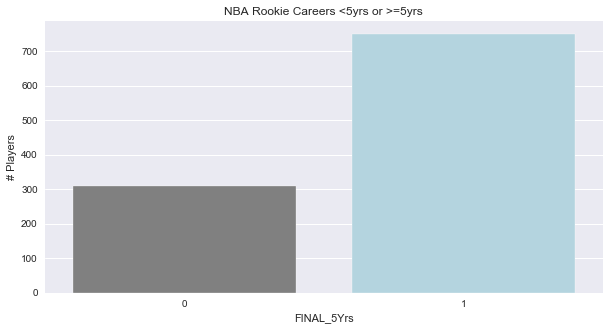

In [29]:
# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['FINAL_5Yrs'], palette= ['grey','lightblue'])
plt.title('NBA Rookie Careers <5yrs or >=5yrs')
plt.ylabel('# Players')
plt.show()

We see in the chart above that our dataset has a class imbalance which will need to be resolved when we model our data

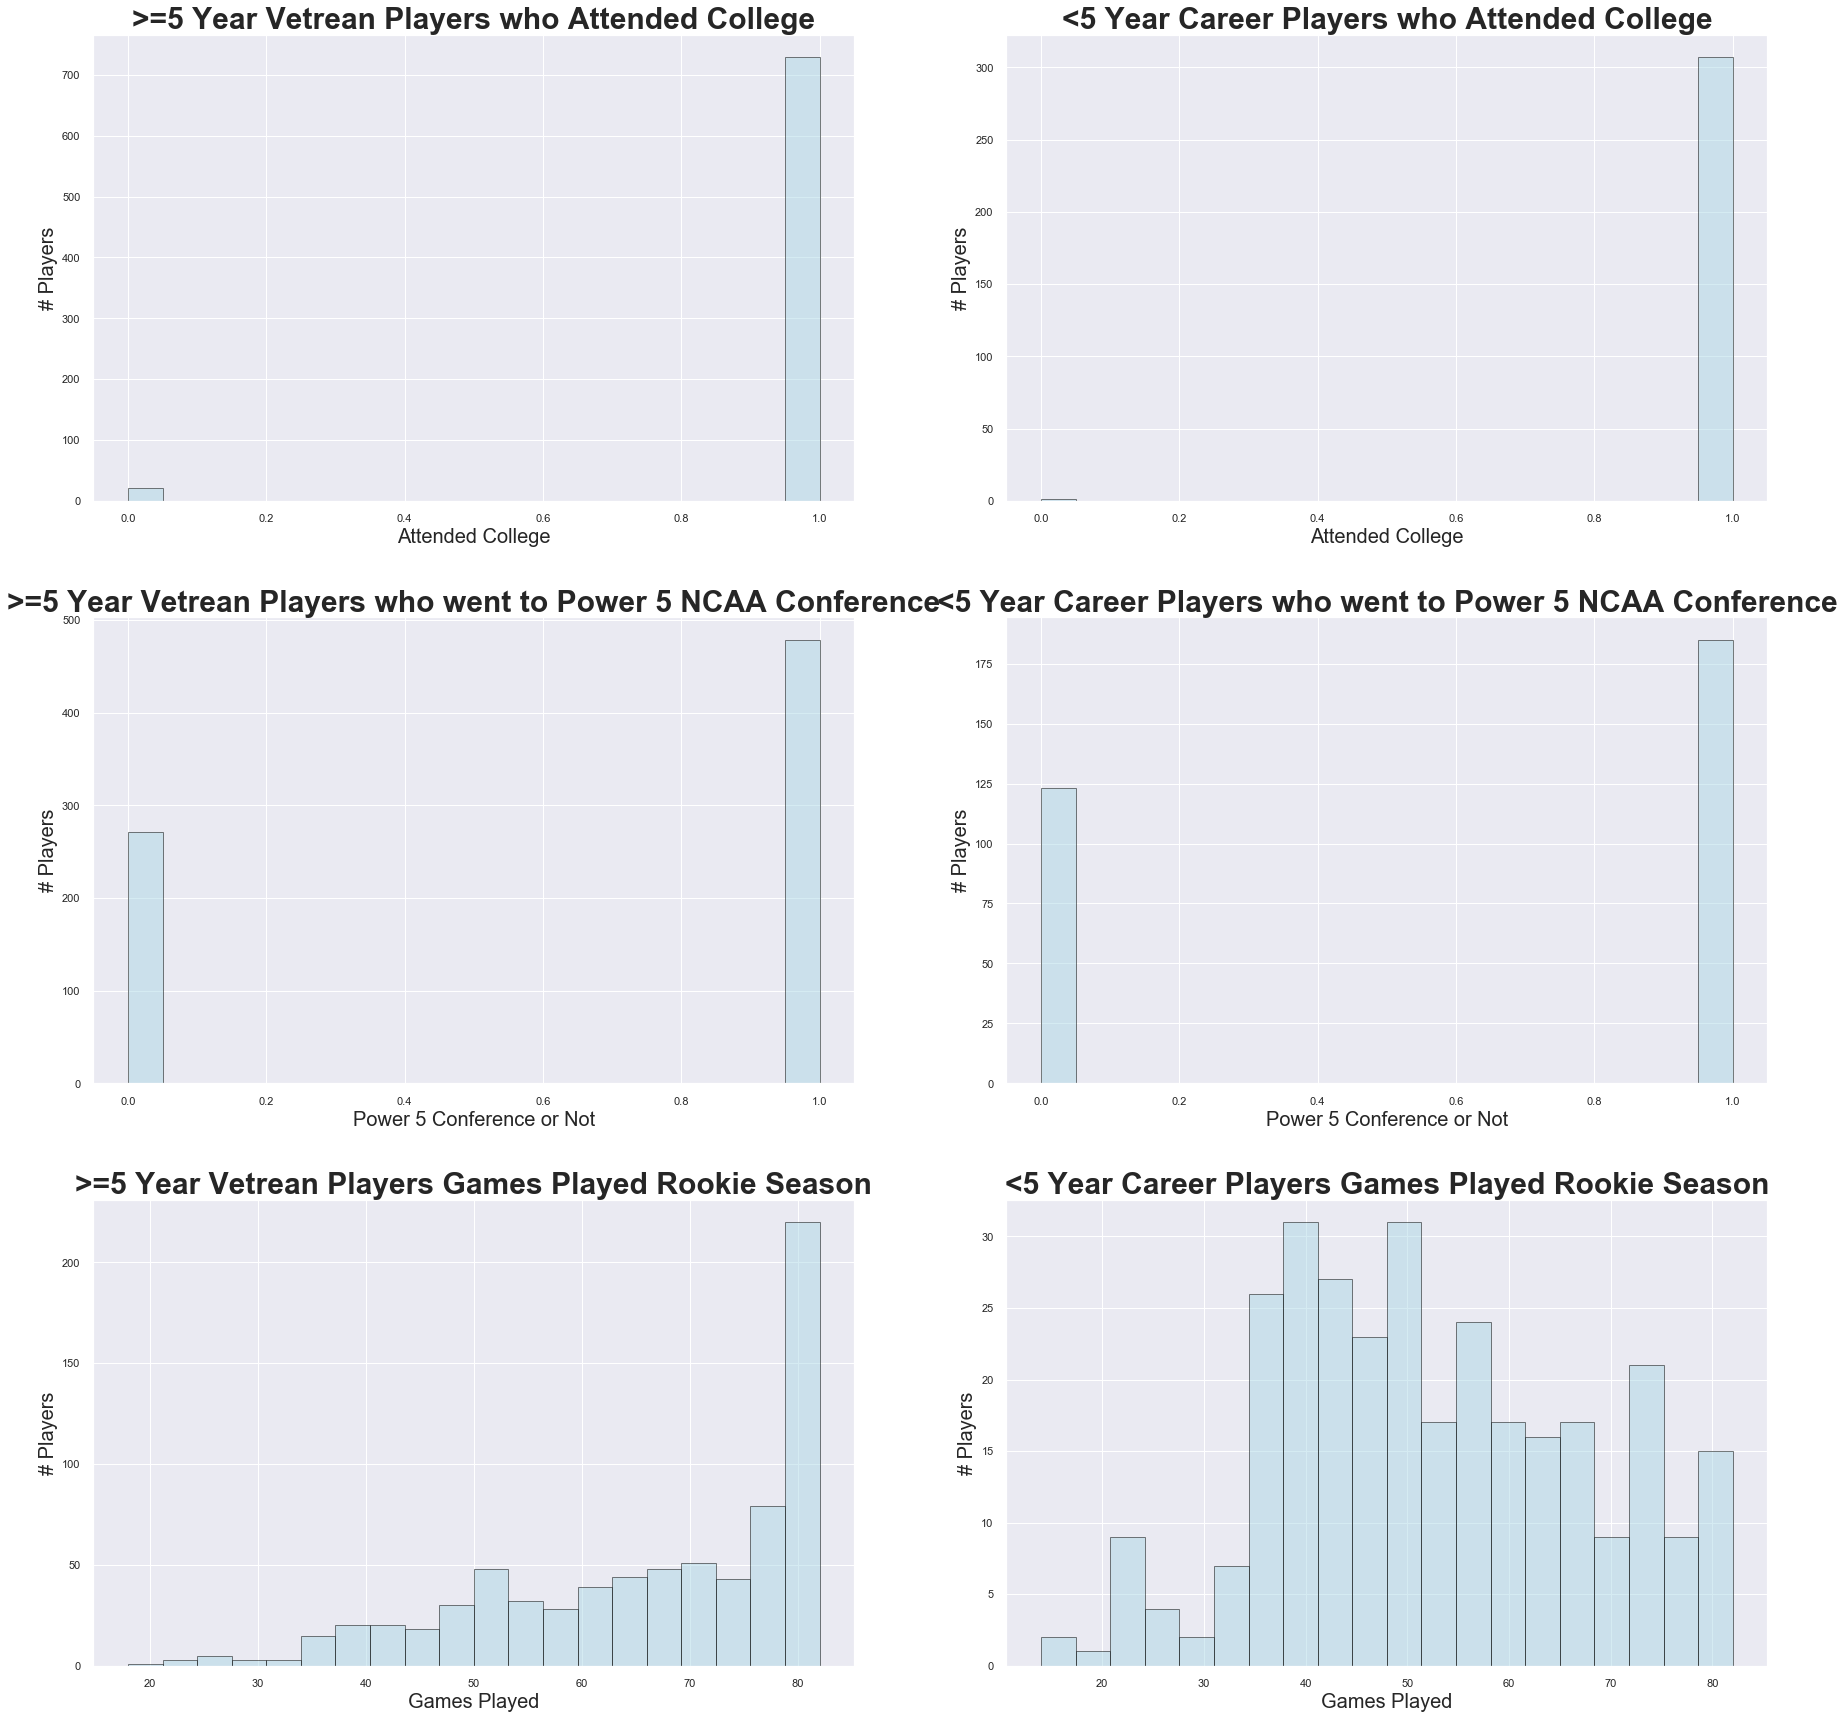

In [123]:
# Histograms of Features

notplay = df[df['FINAL_5Yrs']==0]
yesplay = df[df['FINAL_5Yrs']==1]

sns.set_style('darkgrid')
fig = plt.figure(figsize = (30,30))
fig.subplots_adjust(hspace = .25)
#ax1 and ax2 explain the relationship between attending college and having a longer than average career
ax1 = fig.add_subplot(321)
ax1.hist(yesplay['attend_college'], bins = 20, alpha = .50,edgecolor= 'black',color ='lightblue')
ax1.set_xlabel('Attended College', fontsize = 20)
ax1.set_ylabel('# Players',fontsize = 20)
ax1.set_title('>=5 Year Vetrean Players who Attended College',fontsize = 30,fontweight='bold')

ax2 = fig.add_subplot(322)
ax2.hist(notplay['attend_college'], bins = 20, alpha = .50,edgecolor= 'black',color ='lightblue')
ax2.set_xlabel('Attended College', fontsize = 20)
ax2.set_ylabel('# Players',fontsize = 20)
ax2.set_title('<5 Year Career Players who Attended College',fontsize = 30,fontweight='bold')
#ax3 and ax4 show the relationship between going to power 5 conference for college and if a career will be longer than average 
ax3 = fig.add_subplot(323)
ax3.hist(yesplay['conference'], bins = 20, alpha = .50,edgecolor= 'black',color ='lightblue')
ax3.set_xlabel('Power 5 Conference or Not',fontsize = 20)
ax3.set_ylabel('# Players',fontsize = 20)
ax3.set_title('>=5 Year Vetrean Players who went to Power 5 NCAA Conference',fontsize = 30,fontweight='bold')

ax4 = fig.add_subplot(324)
ax4.hist(notplay['conference'], bins = 20, alpha = .50,edgecolor= 'black',color ='lightblue')
ax4.set_xlabel('Power 5 Conference or Not',fontsize = 20)
ax4.set_ylabel('# Players',fontsize = 20)
ax4.set_title('<5 Year Career Players who went to Power 5 NCAA Conference',fontsize = 30,fontweight='bold')
#ax5 and ax6 show the relationship between how many games a player plays in his rookie season and 
#if a career will be longer than average
ax5 = fig.add_subplot(325)
ax5.hist(yesplay['GP'], bins = 20, alpha = .50,edgecolor= 'black',color ='lightblue')
ax5.set_xlabel('Games Played',fontsize = 20)
ax5.set_ylabel('# Players',fontsize = 20)
ax5.set_title('>=5 Year Vetrean Players Games Played Rookie Season',fontsize = 30,fontweight='bold')

ax6 = fig.add_subplot(326)
ax6.hist(notplay['GP'], bins = 20, alpha = .50,edgecolor= 'black',color ='lightblue')
ax6.set_xlabel('Games Played',fontsize = 20)
ax6.set_ylabel('# Players',fontsize = 20)
ax6.set_title('<5 Year Career Players Games Played Rookie Season',fontsize = 30,fontweight='bold')

plt.show()

# Unhash to save chart
# fig.savefig('ncaa_nba_histo.png',bbox_inches='tight');

Surprisingly what we see in the graphs above is that going to a college in a power 5 conference isn't a good indicator of a players future in the NBA, in fact going to college doesn't even show as much of an indicator. What we do see as a good metric is how many games a rookie plays in is a good indicator of a longer than average career length. The chart on the bottom left is showing a positive relationship between the amount of games played avg career length.

Does it matter when a player was picked in the draft?

In [32]:
df_chi3 = df.groupby('FINAL_5Yrs')['Pk'].value_counts()
df_chi4 = df_chi3.unstack()
df_chi4.fillna(0,inplace = True)
df_chi4.head()

Pk,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,55,56,57,58,59,60,61,62,64,65,68,69,70,71,73,74,75,76,77,79,82,83,84,85,86,87,88,89,90,97,98,100,103,107,116,117,118,124,133,139,141,150,152,154,156,160,165,166,168,190
FINAL_5Yrs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,2.0,1.0,0.0,4.0,0.0,3.0,0.0,0.0,3.0,2.0,4.0,8.0,6.0,4.0,7.0,4.0,10.0,4.0,7.0,4.0,3.0,4.0,8.0,7.0,11.0,7.0,7.0,6.0,5.0,6.0,11.0,10.0,8.0,10.0,4.0,8.0,3.0,2.0,4.0,4.0,5.0,5.0,9.0,7.0,5.0,3.0,5.0,4.0,...,5.0,4.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,16.0,27.0,23.0,27.0,24.0,28.0,27.0,26.0,27.0,31.0,18.0,22.0,24.0,19.0,22.0,16.0,19.0,19.0,16.0,19.0,19.0,17.0,20.0,14.0,8.0,9.0,10.0,10.0,11.0,7.0,8.0,7.0,9.0,4.0,5.0,3.0,10.0,7.0,10.0,9.0,4.0,5.0,10.0,4.0,7.0,4.0,8.0,3.0,3.0,3.0,...,5.0,1.0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0


In [33]:
df_chi5 = df_chi4.iloc[0:2,0:5]
df_chi5 = pd.DataFrame(df_chi5.sum(axis=1)).rename(columns={0:'Top_5'})
df_chi5

,Top_5
FINAL_5Yrs,
0,5.0
1,117.0


In [34]:
df_chi6 = df_chi4.iloc[0:2,5:14]
df_chi6 = pd.DataFrame(df_chi6.sum(axis=1)).rename(columns={0:'Lottery_6_14'})
df_chi6

,Lottery_6_14
FINAL_5Yrs,
0,24.0
1,222.0


In [35]:
df_chi7 = df_chi4.iloc[0:2,14:30]
df_chi7 = pd.DataFrame(df_chi7.sum(axis=1)).rename(columns={0:'1st_Rd_15-30'})
df_chi7

,1st_Rd_15-30
FINAL_5Yrs,
0,99.0
1,236.0


In [36]:
df_chi8 = df_chi4.iloc[0:2,30:60]
df_chi8 = pd.DataFrame(df_chi8.sum(axis=1)).rename(columns={0:'2nd_rd'})
df_chi8

,2nd_rd
FINAL_5Yrs,
0,150.0
1,150.0


In [37]:
df_chi9 = df_chi4.iloc[0:2,60:]
df_chi9 = pd.DataFrame(df_chi9.sum(axis=1)).rename(columns={0:'Undrafted'})
df_chi9

,Undrafted
FINAL_5Yrs,
0,30.0
1,25.0


In [38]:
frames = [df_chi5,df_chi6,df_chi7,df_chi8,df_chi9]
df_chi10 = pd.concat(frames,axis=1)
df_chi10['TOP_5_Pick'] = 117/122*100
df_chi10['Lottery_Pick'] = 222/246*100
df_chi10['1st_Rd_Pick'] = 236/335*100
df_chi10['2nd_Rd_Pick'] = 150/300*100
df_chi10['Undrafted_Pick'] = 25/55*100
df_chi11 = df_chi10.iloc[1:,5:]
df_chi11

,TOP_5_Pick,Lottery_Pick,1st_Rd_Pick,2nd_Rd_Pick,Undrafted_Pick
FINAL_5Yrs,,,,,
1,95.901639,90.243902,70.447761,50.0,45.454545


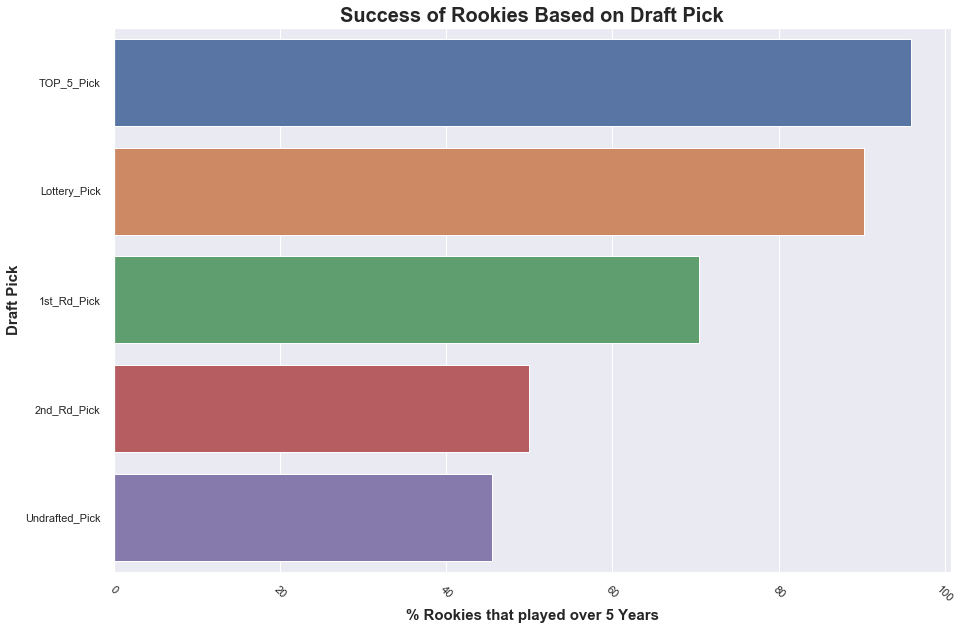

In [124]:
fig,ax=plt.subplots(figsize=(15,10))
sns.set(style='darkgrid')
ax.set_xlabel('% Rookies that played over 5 Years',fontweight='bold', fontsize=(15))
plt.xticks(rotation=-45)
ax.set_ylabel('Draft Pick',fontweight='bold', fontsize=(15))
ax.set_title('Success of Rookies Based on Draft Pick', fontweight='bold', fontsize=(20))

ax =sns.barplot(data=df_chi11,orient='h')

# fig.savefig('success_draft_pick.png',bbox_inches='tight');

We see above that there is a negative relationship between draft pick used and the average length of a rookies career. We see that the earlier the pick the more likely a player is to having a longer than average career.

## Hypothesis Testing

Is there a relationship between the team selecting a player and if they will have a longer than average career?

### #1 Chi Square Test

Hypothesis Testing:

Null: There is no relationship between the Team and whether or not players last 5 years in the NBA

Alternative: There is a relationship between the Team and whether or not players last 5 years in the NBA

In [40]:
df_chi = df.groupby('FINAL_5Yrs')['Team'].value_counts()
df_chi2 = df_chi.unstack()
df_chi2.fillna(0,inplace = True)
df_chi2.head()

Team,ATL,BOS,CHA,CHI,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NJN,NOH,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS
FINAL_5Yrs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,15,14,4,22,6,12,11,6,15,7,13,10,10,8,10,11,11,14,7,8,8,6,9,10,15,13,8,1,14,10
1,25,23,10,40,29,28,21,29,31,25,23,34,21,15,14,27,23,26,24,26,28,17,26,33,26,33,17,13,30,33


In [41]:
# contingency table
stat, p, dof, expected = chi2_contingency(df_chi2)
print(expected)

#interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f)' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
#interpret p-value
alpha= 1-prob
print('signigicance=%.3f, p=%.3f,' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else: 
    print('Independent (fail to reject)')

[[11.64461248 10.77126654  4.07561437 18.04914934 10.18903592 11.64461248
   9.31568998 10.18903592 13.39130435  9.31568998 10.48015123 12.80907372
   9.02457467  6.69565217  6.98676749 11.06238185  9.8979206  11.64461248
   9.02457467  9.8979206  10.48015123  6.69565217 10.18903592 12.51795841
  11.93572779 13.39130435  7.2778828   4.07561437 12.80907372 12.51795841]
 [28.35538752 26.22873346  9.92438563 43.95085066 24.81096408 28.35538752
  22.68431002 24.81096408 32.60869565 22.68431002 25.51984877 31.19092628
  21.97542533 16.30434783 17.01323251 26.93761815 24.1020794  28.35538752
  21.97542533 24.1020794  25.51984877 16.30434783 24.81096408 30.48204159
  29.06427221 32.60869565 17.7221172   9.92438563 31.19092628 30.48204159]]
probability=0.950, critical=42.557, stat=23.615)
Independent (fail to reject H0)
signigicance=0.050, p=0.748,
Independent (fail to reject)


We FAIL to reject the null hypothesis because chi square statistic (23.615) is less than the critical value (42.557)

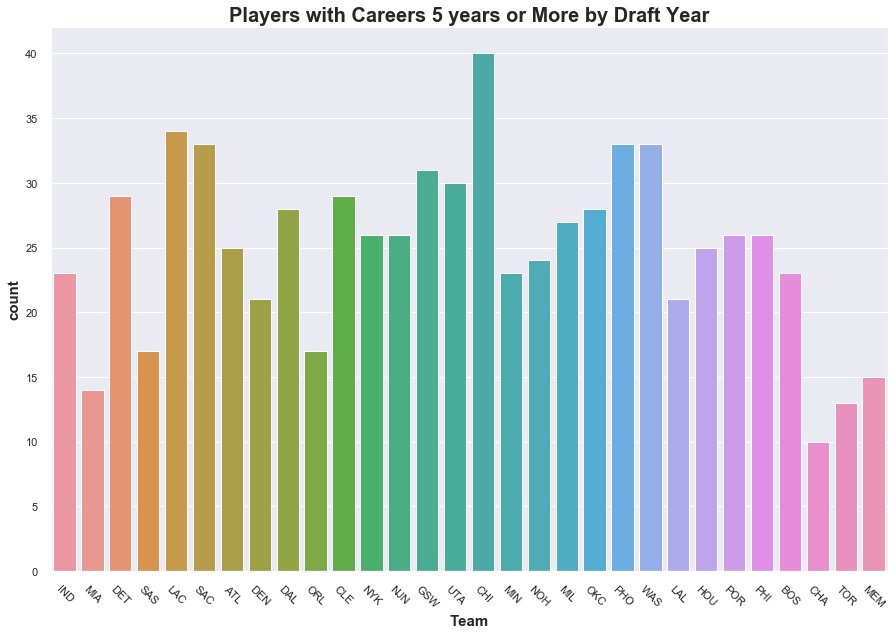

In [126]:
df_draft = df[df['FINAL_5Yrs']==1]

fig,ax=plt.subplots(figsize=(15,10))
sns.set(style='darkgrid')
ax.set_xlabel('Draft Year',fontweight='bold', fontsize=(15))
plt.xticks(rotation=-45)
ax.set_ylabel('# of Veterans over 5 Years',fontweight='bold', fontsize=(15))
ax.set_title('Players with Careers 5 years or More by Draft Year', fontweight='bold', fontsize=(20))

ax =sns.countplot(df_draft['Team'],data=df_draft)

# fig.savefig('count_plot_team.png',bbox_inches='tight');

We see from Chi Square test and the histogram above that there isn't a relationship between team and future career length.

### #2 Two Sample T Test

Is there a relationship between average minutes per game and having a career longer than average?

Hypothesis Testing:

Null: No statistical difference between minutes and whether or not players last 5 years in the NBA  u1 = u2

Alternative: There is a statisitcal difference between minutes and whether or not players last 5 years in the NBA u1 =/ u2

In [43]:
df['FINAL_5Yrs'].value_counts()

1    750
0    308
Name: FINAL_5Yrs, dtype: int64

In [44]:
notplay = df[df['FINAL_5Yrs']==0]
yesplay = df[df['FINAL_5Yrs']==1]

In [45]:
notplay['MIN'].describe()

count    308.000000
mean      13.214286
std        5.588896
min        3.100000
25%        9.000000
50%       12.100000
75%       16.100000
max       33.500000
Name: MIN, dtype: float64

In [46]:
yesplay['MIN'].describe()

count    750.000000
mean      19.961467
std        8.470399
min        4.500000
25%       13.100000
50%       19.050000
75%       26.300000
max       40.900000
Name: MIN, dtype: float64

In [47]:
stats.ttest_ind(notplay['MIN'],yesplay['MIN'], equal_var = False)

Ttest_indResult(statistic=-15.198576450908643, pvalue=2.516826398434337e-46)

We CAN reject the null hypothesis because our pvalue (2.51e-46) is less than 0.05 (alpha set at .05)

What we see from this T-test is the more minutes a rookie gets the more likely he is to play five or more seasons.

### #3 One way ANOVA

We have seen that there isn't a relationship between a team and career length but there is a relationship between minutes and career length. To bring this full circle, is there a relationship between minutes and the team a rookie is on?

Hypothesis Testing:

Null: No statistical difference between minutes played and Teams

Alternative: There is a statisitcal difference between minutes played and Teams

In [48]:
stats.f_oneway(df['MIN'][df['Team'] == 'CHI'],
               df['MIN'][df['Team'] == 'GSW'],
               df['MIN'][df['Team'] == 'SAC'],
               df['MIN'][df['Team'] == 'LAC'],
               df['MIN'][df['Team'] == 'UTA'],
               df['MIN'][df['Team'] == 'PHO'],
               df['MIN'][df['Team'] == 'WAS'],
               df['MIN'][df['Team'] == 'POR'],
               df['MIN'][df['Team'] == 'NJN'],
               df['MIN'][df['Team'] == 'DAL'],
               df['MIN'][df['Team'] == 'ATL'],
               df['MIN'][df['Team'] == 'MIL'],
               df['MIN'][df['Team'] == 'BOS'],
               df['MIN'][df['Team'] == 'OKC'],
               df['MIN'][df['Team'] == 'IND'],
               df['MIN'][df['Team'] == 'PHI'],
               df['MIN'][df['Team'] == 'DET'],
               df['MIN'][df['Team'] == 'CLE'],
               df['MIN'][df['Team'] == 'NYK'],
               df['MIN'][df['Team'] == 'MIN'],
               df['MIN'][df['Team'] == 'DEN'],
               df['MIN'][df['Team'] == 'HOU'],
               df['MIN'][df['Team'] == 'NOH'],
               df['MIN'][df['Team'] == 'LAL'],
               df['MIN'][df['Team'] == 'SAS'],
               df['MIN'][df['Team'] == 'MIA'],
               df['MIN'][df['Team'] == 'MEM'],
               df['MIN'][df['Team'] == 'ORL'],
               df['MIN'][df['Team'] == 'TOR'],
               df['MIN'][df['Team'] == 'CHA'])
               

F_onewayResult(statistic=2.168178018732155, pvalue=0.0003642580578649719)

We CAN reject the null hypothesis because our pvalue is less than 0.05 (alpha set at .05).

We see from the ANOVA test above that there actually is a relationship between the team a rookie is on and the average amount of minutes a rookie gets per game. This is interesting, as we know more minutes usually indicates a longer than average career.

In [49]:
min_order = df.groupby('Team')['MIN'].median().sort_values(ascending = False).index

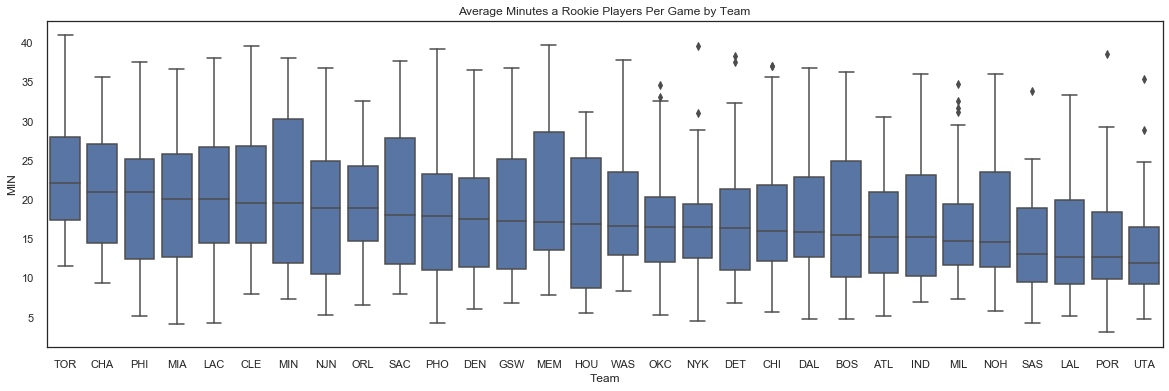

In [137]:
plt.figure(figsize=(20,6))
plt.title('Average Minutes a Rookie Players Per Game by Team')
sns.boxplot(x='Team',y='MIN',data=df,color='b', order=min_order);

# plt.savefig('avg_min_team_boxplot.png',bbox_inches='tight');

The chart above breaks down the teams that give more minutes to rookies.

Do rookies who are picked earlier in the draft get more minutes on average?

In [51]:
min_order2 = df.groupby('Pk')['MIN'].median().sort_values(ascending = False).index

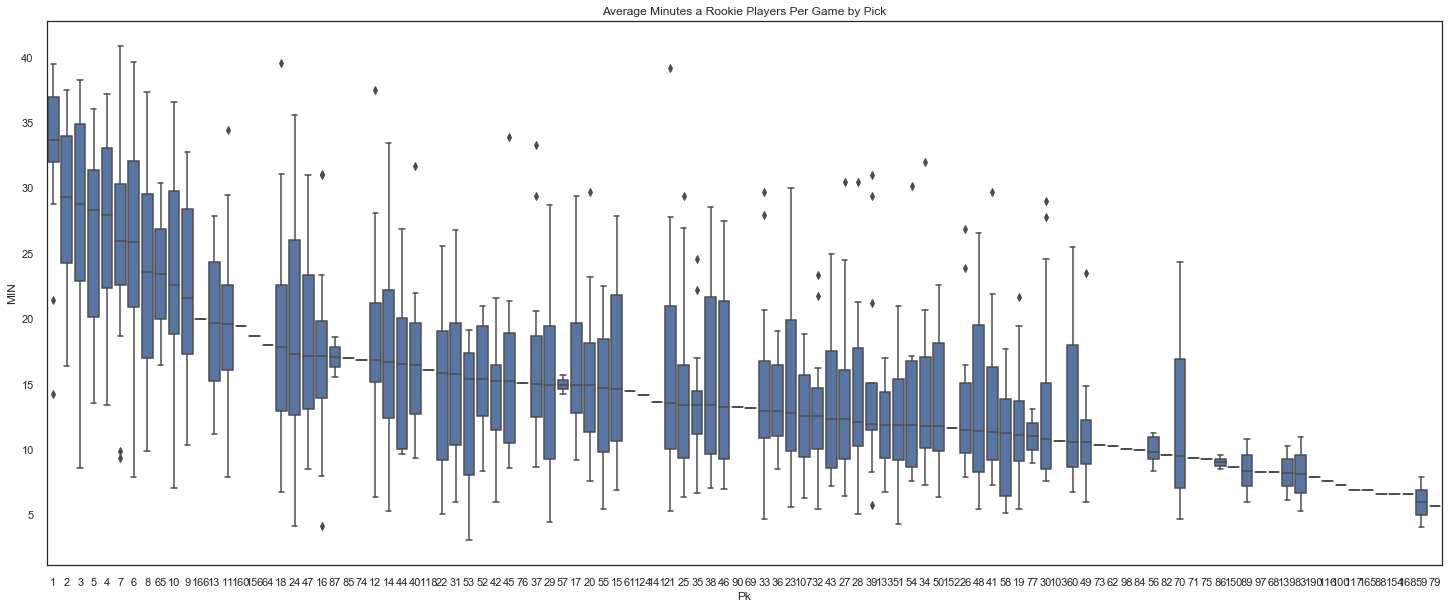

In [134]:
plt.figure(figsize=(25,10))
plt.title('Average Minutes a Rookie Players Per Game by Pick')
sns.boxplot(x='Pk',y='MIN',data=df,color='b', order=min_order2);

# plt.savefig('avg_min_pick_boxplot.png',bbox_inches='tight');

We see quite clearly that the later you are picked in the draft the less minutes you are likely to receive.

## Feature Selection & More Feature Engineering

In [53]:
# First data frame is used for Log Reg & Knn to determine which features to use
df1= df.drop(columns=["College",'Name','TARGET_5Yrs','Draft_Yr','FGA','AST_TOV'])#'Team',"3P%", 'FT%', '3PA_Shot', 'AST_TOV', 'attend_college', 'conference'


In [54]:
# Team column broken down to individual teams to use as a categorical variable
df1 = pd.get_dummies(df1, columns=["Team"], drop_first=True)

In [55]:
# Second data fram is used for decision and random forest tree because the extra features can help with modeling
df2= df.drop(columns=["College",'Name','TARGET_5Yrs','Draft_Yr'])#'Team',"3P%", 'FT%', '3PA_Shot', 'AST_TOV', 'attend_college', 'conference'

In [56]:
df2 = pd.get_dummies(df2, columns=["Team"], drop_first=True)

In [57]:
df.corr()['FINAL_5Yrs'].sort_values(ascending = False)

FINAL_5Yrs        1.000000
TARGET_5Yrs       0.899888
GP                0.402354
MIN               0.368323
PTS               0.347726
FGM               0.346181
DREB              0.344193
REB               0.334666
FGA               0.322110
FTM               0.308246
FTA               0.302987
TOV               0.285795
OREB              0.280410
PPP               0.276911
STL               0.274750
True_FG%          0.256613
BLK               0.237380
FG%               0.210143
AST               0.199273
FT%               0.146148
3P Made           0.121758
3PA               0.110435
3P%               0.056157
Draft_Yr          0.055950
FTR               0.054166
AST_TOV           0.037992
conference        0.035724
3PA_Shot         -0.000026
Hasst%           -0.009827
attend_college   -0.078804
TOV%             -0.089345
Pk               -0.320241
Name: FINAL_5Yrs, dtype: float64

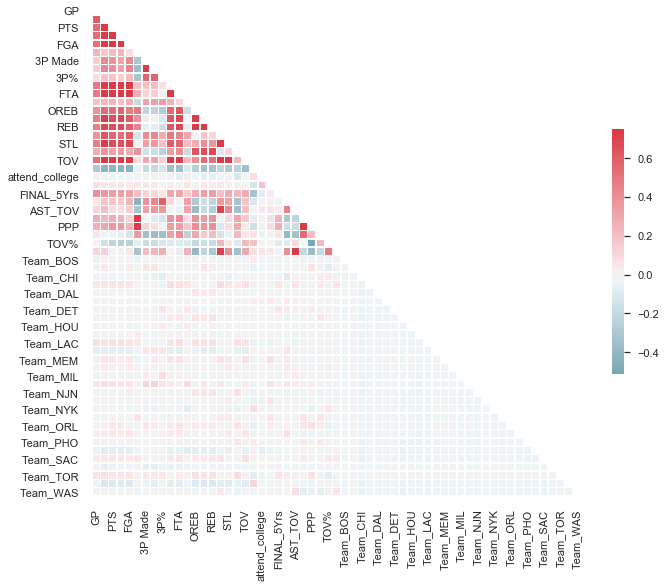

In [140]:
sns.set(style="white")
corr = df2.corr() 

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# f.savefig('corr_heatmap.png',bbox_inches='tight');

## Modeling

### Train Test Split

In [59]:
# Remove target variable to begin modeling
target = df1['FINAL_5Yrs']
features = df1.drop(['FINAL_5Yrs'], axis=1)

In [60]:
target1 = df2['FINAL_5Yrs']
features1 = df2.drop(['FINAL_5Yrs'], axis=1)

### Logestic Regression Modeling

In [61]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25,test_size=0.20)

log = LogisticRegression(class_weight='balanced')
log.fit(X_train, y_train)
log_preds = log.predict(X_test)

log_f1 = metrics.f1_score(y_test, log_preds)

log_acc = metrics.accuracy_score(y_test, log_preds)

print('Test F1 score: ', log_f1)
print('Test Accuracy score: ', log_acc)

Test F1 score:  0.8464163822525598
Test Accuracy score:  0.7877358490566038


/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Our baseline model, to put the Accuracy score in perspective, if the model were to pick the dominant class every time it would have a 70% Accuracy.

In [62]:
# Run for loop to test which features will improve the model's F1 & Acc score
cols = ['REB','GP', 'PTS', 'FGM', 'FG%', '3P Made', '3PA', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'AST', 'STL', 'BLK','TOV', 'Pk', "3P%", 'FT%', '3PA_Shot', 'attend_college', 'conference']

In [63]:
# Will output the feature that needs to be dropped to improve the log model
for x in cols:
    df_test= df1.drop(columns=[x])
    target = df_test['FINAL_5Yrs']
    features = df_test.drop(['FINAL_5Yrs'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25,test_size=0.20)
    lr = LogisticRegression(class_weight='balanced')
    lr.fit(X_train, y_train)
    lr_preds = lr.predict(X_test)
    lr_f1 = metrics.f1_score(y_test, lr_preds)
    lr_acc = metrics.accuracy_score(y_test, lr_preds)
    if lr_f1 > log_f1 or lr_acc > log_acc:
        print(x,'LR Test F1 score: ', lr_f1, (lr_f1-log_f1))
        print(x,'LR Test Accuracy score: ', lr_acc, (lr_acc-log_acc))
    else:
        continue

/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

### F-Test Feature Selection

In [64]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25,test_size=0.20)

scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train)
#transform the training data
X_train = pd.DataFrame(data = scaler.transform(X_train), columns = features.columns)
#transform the testing dat
X_test = pd.DataFrame(data = scaler.transform(X_test), columns = features.columns)

selector = SelectKBest(f_regression, k=22)

selector.fit(X_train, y_train)

/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


SelectKBest(k=22, score_func=<function f_regression at 0x1a195aa320>)

In [65]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]
# X_train = X_train[selected_columns]
# X_test = X_test[selected_columns]

In [66]:
log_kbest = LogisticRegression(class_weight='balanced')
log_kbest = log_kbest.fit(X_train[selected_columns], y_train)

log_kpreds = log_kbest.predict(X_test[selected_columns])

log_kf1 = metrics.f1_score(y_test, log_kpreds)

log_kacc = metrics.accuracy_score(y_test, log_kpreds)

print('Test F1 score: ', log_kf1)
print('Test Accuracy score: ', log_kacc)

/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test F1 score:  0.8185053380782917
Test Accuracy score:  0.7594339622641509


A worse result across the board than our baseline Logistic Regression model

### Gridsearch - Log Regression

In [67]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25,test_size=0.20)

In [68]:
logreg = LogisticRegression(class_weight = 'balanced',solver='liblinear')

In [69]:
logreg

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [70]:
parameters = {'C': [0.25,0.35,0.5,0.75,1.0],
             'max_iter': [100,200,300,400,500]}

In [71]:
grid_tree1=GridSearchCV(logreg, parameters, cv=5, scoring='f1',verbose =1,n_jobs=-1)

grid_tree1.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    8.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.25, 0.35, 0.5, 0.75, 1.0], 'max_iter': [100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [72]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree1.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree1.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree1.best_estimator_)

0.7894384764339318
{'C': 0.5, 'max_iter': 100}
LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [73]:
#Predict the response for test dataset
y_pred = grid_tree1.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Test F1 Score:",metrics.f1_score(y_test, y_pred))
print("Test Accuracy Score:",metrics.accuracy_score(y_test, y_pred))

Test F1 Score: 0.845360824742268
Test Accuracy Score: 0.7877358490566038


Right around what we saw from our baseline model.

### Gridsearch - Log Regression with F-Test

In [74]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25,test_size=0.20)

scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train)
#transform the training data
X_train = pd.DataFrame(data = scaler.transform(X_train), columns = features.columns)
#transform the testing dat
X_test = pd.DataFrame(data = scaler.transform(X_test), columns = features.columns)

selector = SelectKBest(f_regression, k=22)

selector.fit(X_train, y_train)

/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


SelectKBest(k=22, score_func=<function f_regression at 0x1a195aa320>)

In [75]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]
# X_train = X_train[selected_columns]
# X_test = X_test[selected_columns]

In [76]:
logreg_kbest = LogisticRegression(class_weight = 'balanced',solver='liblinear')

In [77]:
logreg_kbest

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [78]:
parameters = {'C': [0.25,0.35,0.5,0.75,1.0],
             'max_iter': [100,200,300,400,500]}

In [79]:
grid_tree2=GridSearchCV(logreg_kbest, parameters, cv=5, scoring='f1',verbose =1,n_jobs=-1)

grid_tree2.fit(X_train[selected_columns], y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.25, 0.35, 0.5, 0.75, 1.0], 'max_iter': [100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [80]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree2.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree2.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree2.best_estimator_)

0.784425931294902
{'C': 0.35, 'max_iter': 100}
LogisticRegression(C=0.35, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [81]:
#Predict the response for test dataset
y_pred = grid_tree2.best_estimator_.predict(X_test[selected_columns])

# Model Accuracy, how often is the classifier correct?
print("Test F1 Score:",metrics.f1_score(y_test, y_pred))
print("Test Accuracy Score:",metrics.accuracy_score(y_test, y_pred))

Test F1 Score: 0.822695035460993
Test Accuracy Score: 0.7641509433962265


Worse result than our baseline and gridsearch

### KNN

In [82]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25,test_size=0.20)

scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train)
#transform the training data
X_train = pd.DataFrame(data = scaler.transform(X_train), columns = features.columns)
#transform the testing data
X_test = pd.DataFrame(data = scaler.transform(X_test), columns = features.columns)

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

knn_preds = knn.predict(X_test)

knn_f1 = metrics.f1_score(y_test, knn_preds)

knn_acc = metrics.accuracy_score(y_test, knn_preds)

print('Test F1 score: ', knn_f1)
print('Test Accuracy score: ', knn_acc)

/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


Test F1 score:  0.8414634146341463
Test Accuracy score:  0.7547169811320755


A KNN model before solving for the class imbalance. Worse than our baseline but not as bad as we thought it could be.

### Upsampling KNN

In [83]:
750/(750+308)

0.7088846880907372

In [84]:
# separate minority and majority classes
short = df1[df1['FINAL_5Yrs']==0]
long = df1[df1['FINAL_5Yrs']==1]

In [85]:
print('short count: '+ str(len(short)))
print('long count: '+ str(len(long)))

short count: 308
long count: 750


In [86]:
short_upsampled = resample(short,
                          replace=True, # sample with replacement
                          n_samples=len(long), # match number in majority class
                          random_state=25) # reproducible results

In [87]:
short_upsampled.shape

(750, 57)

In [88]:
# combine majority and upsampled minority
upsampled = pd.concat([long, short_upsampled])

# check new class counts
upsampled.FINAL_5Yrs.value_counts()

1    750
0    750
Name: FINAL_5Yrs, dtype: int64

In [89]:
len(upsampled)

1500

In [90]:
# Remove target variable to begin modeling
target = df1['FINAL_5Yrs']
features = df1.drop(['FINAL_5Yrs'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25,test_size=0.20)

y_train = upsampled.FINAL_5Yrs
X_train = upsampled.drop('FINAL_5Yrs', axis=1)

scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train)
#transform the training data
X_train = pd.DataFrame(data = scaler.transform(X_train), columns = features.columns)
#transform the testing dat
X_test = pd.DataFrame(data = scaler.transform(X_test), columns = features.columns)

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

knn_preds = knn.predict(X_test)

knn_f1 = metrics.f1_score(y_test, knn_preds)

knn_acc = metrics.accuracy_score(y_test, knn_preds)

print('Test F1 score: ', knn_f1)
print('Test Accuracy score: ', knn_acc)

/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


Test F1 score:  0.7912087912087912
Test Accuracy score:  0.7311320754716981


Upsampling the data actually made the model perform worse, both models performed worse than the gridsearch and regular logistic regression.

### Decision Tree

In [91]:
X_train, X_test, y_train, y_test = train_test_split(features1, target1, random_state=25,test_size=0.20)

dtc = DecisionTreeClassifier(random_state = 25, class_weight='balanced')

dtc.fit(X_train, y_train)

dtc_preds  = dtc.predict(X_test)

dtc_f1 = metrics.f1_score(y_test, dtc_preds)

dtc_acc = metrics.accuracy_score(y_test, dtc_preds)

print('Test F1 score: ', dtc_f1)
print('Test Accuracy score: ', dtc_acc)

Test F1 score:  0.8129032258064518
Test Accuracy score:  0.7264150943396226


Worse than our baseline model.

### Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(features1, target1, random_state=25,test_size=0.20)

rfc = RandomForestClassifier(random_state = 25, n_estimators=200, max_features=10, class_weight='balanced')
rfc.fit(X_train, y_train)
rfc_preds = rfc.predict(X_test)

rfc_f1 = metrics.f1_score(y_test, rfc_preds)
rfc_acc = metrics.accuracy_score(y_test, rfc_preds)

# checking accuracy on the test data
print('Test F1 score: ', rfc_f1)
print('Test Accuracy score: ', rfc_acc)

Test F1 score:  0.8623853211009174
Test Accuracy score:  0.7877358490566038


The random forest model performed better on the F1 score but around the same in accuracy. The model is predicting the positive class at a highier rate than the other models.

### Gridsearch - Random Forest

In [93]:
#create a dictionary of all the parameters you want to tune
param_grid2 = { 
    'n_estimators': [100,200,400,500],
    'max_features': ['auto',None,35],
    'max_depth' : [5,7,9],
    'criterion' : ['gini','entropy']
    
}

In [94]:
X_train, X_test, y_train, y_test = train_test_split(features1, target1, random_state=25,test_size=0.20)
rfc_CV = RandomForestClassifier(random_state = 25, class_weight='balanced')
rfc_CV = GridSearchCV(estimator=rfc_CV, param_grid=param_grid2, cv= 5, scoring='f1', verbose=1, n_jobs=-1)
rfc_CV.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=25, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 400, 500], 'max_features': ['auto', None, 35], 'max_depth': [5, 7, 9], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [95]:
# Identify the best params 
print(rfc_CV.best_params_)
print(rfc_CV.best_estimator_)


#Identify the best score during fitting with cross-validation
print(rfc_CV.best_score_)

#predict on the test set
test_preds_rfc_CV = rfc_CV.best_estimator_.predict(X_test)

# checking accuracy and F1
print("Accuracy:",metrics.accuracy_score(y_test, test_preds_rfc_CV))
print("F1:",metrics.f1_score(y_test, test_preds_rfc_CV))

{'criterion': 'entropy', 'max_depth': 9, 'max_features': 35, 'n_estimators': 500}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=9, max_features=35,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=25, verbose=0, warm_start=False)
0.8358224820674526
Accuracy: 0.7735849056603774
F1: 0.8441558441558441


Our GridSearch Random Forest model performed worse than the regular Random Forest model.

### Voting Classifier

In [96]:
voting_clf = VotingClassifier(
                estimators=[('knneighbors', knn), ('decisiontree', dtc), ('logreg', log), ('randomforest', rfc)], 
                voting='hard', weights= [1,1,3,3])

voting_clf.fit(X_train, y_train)

vc_preds = voting_clf.predict(X_test)

vc_f1 = metrics.f1_score(y_test, vc_preds)

vc_acc = metrics.accuracy_score(y_test, vc_preds)

print('Test F1 score: ', vc_f1)
print('Test Accuracy score: ', vc_acc)

/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test F1 score:  0.8655737704918033
Test Accuracy score:  0.8066037735849056


Our best model so far, finally above 80% on accuracy and still have a similar F1 score to our best Random Forest. We saw the improvement by the weighting the voting towards our two best models, the random forest and the logistic regression.

### XG Boost

In [97]:
labels = df2['FINAL_5Yrs']

In [98]:
labels_removed_df = df2.drop('FINAL_5Yrs', axis=1, inplace=False)

scaler = StandardScaler()
scaled_df = scaler.fit_transform(labels_removed_df)

X_train, X_test, y_train, y_test = train_test_split(scaled_df, labels)

/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [99]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [5,6,7],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [100,200,250,300],
}

In [100]:
clf = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='f1', cv=5, n_jobs=-1,verbose=1)
grid_clf.fit(scaled_df, labels)
best_parameters = grid_clf.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)
f1_train= f1_score(y_train, training_preds)
f1_val= f1_score(y_test, val_preds)
print("")
print("Training Accuracy Score: {:.4}%".format(training_accuracy * 100))
print("Training F1 Score: {:.4}%".format(f1_train * 100))
print("Test Accuracy Score: {:.4}%".format(val_accuracy * 100))
print("Test F1 Score: {:.4}%".format(f1_val * 100))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   21.8s finished


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 5
min_child_weight: 10
n_estimators: 250
subsample: 0.7

Training Accuracy Score: 96.6%
Training F1 Score: 97.57%
Test Accuracy Score: 96.6%
Test F1 Score: 97.76%


Ya so this is like a really tight race to decide what our best model is... So I think we are going to roll with our XGBoost? Glad we can all agree.

### XG Boost Confusion Matrix

In [101]:
cm = confusion_matrix(y_test,val_preds)
classes = ['<5 Years', '>=5 Years']

In [102]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[ 60   7]
 [  2 196]]


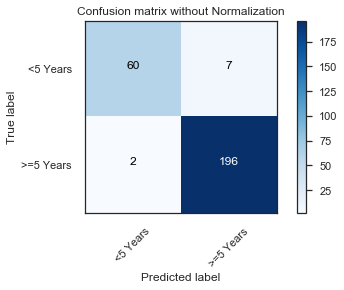

In [103]:
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix without Normalization', cmap=plt.cm.Blues)

[[0.89552239 0.10447761]
 [0.01010101 0.98989899]]


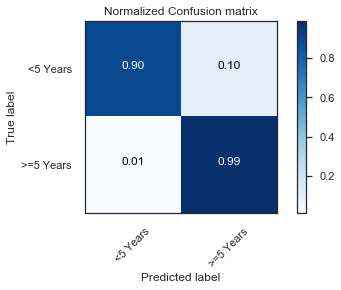

In [142]:
# Normaized confusion matrix takes into account class imbalance.
plot_confusion_matrix(cm, classes, normalize=True, title='Normalized Confusion matrix', cmap=plt.cm.Blues)

In [105]:
TP = 174
TN = 80
FP = 7
FN = 4

In [106]:
Accuracy = (TP+TN)/(TP+TN+FP+FN)
Precision = (TP/ float(TP+FP))
Recall = (TP/ float(TP+FN))
F1 = 2*Precision*Recall / (Precision+Recall)

print('Accuracy Score',Accuracy)
print('Precision Score',Precision)
print('Recall Score',Recall)
print('F1 Score',F1)

Accuracy Score 0.9584905660377359
Precision Score 0.9613259668508287
Recall Score 0.9775280898876404
F1 Score 0.9693593314763231


The confusion matrix above helps us visualize where our best model is missing. What we learn is that we are incorrectly predicting more positives than negatives but neither by a particularly significant margin.

## Model Testing on 2012 NBA Draft Data Set

Having a model that performs well on a test set from the train test split method is great but you're test set could have similar trends to your training data that don't exist in a normal draft class. So let's put our model to the test, how well could it predict the future careers of the 2012 NBA draft class?

In [107]:
df_2012a = pd.read_csv('2012_draft_nba_rookie_stats.csv',index_col=0)
df_2012b = pd.read_csv('2012_draft_nba_rookie_draft_info.csv',index_col=0)

In [108]:
df_2012 = df_2012a.merge(df_2012b, on='Player', how='inner')

In [109]:
#Created a function that will quickly clean up our datasets that we upload
def cleanup(data,year):
    # Created a dictionary to replace all power 5 teams with a 1
    conf_dict = {'Kentucky':1,'Duke':1,'UNC':1,'UCLA':1,
'Arizona':1,'Kansas':1,'Syracuse':1,'Georgia Institute of Technology':1,
'University of Louisville':1,'University of Michigan':1,'University of Notre Dame':1,'Ohio State':1,
'North Carolina State University':1,'University of Alabama':1,'Michigan State':1,'University of Arkansas':1,
'Maryland':1,'Indiana University':1,'Louisiana State University':1,'Stanford University':1,
'Purdue':1,'Florida':1,'Tennessee':1,'University of Missouri':1,
'Oklahoma State University':1,'Illinois':1,'Clemson University':1,'Washington':1,
'Virginia':1,'Wake Forest University':1,'University of Pittsburgh':1,'Florida State':1,
'University of California':1,'Oregon State':1,'University of Minnesota':1,'Iowa State University':1,
'University of Utah':1,'USC':1,'University of Iowa':1,'Boston College':1,
'Arizona State University':1,'Georgia':1,'Colorado':1,'University of Oklahoma':1,
'Auburn University':1,'Wisconsin':1,'Texas':1,'University of Oregon':1,
'Vanderbilt':1,'Baylor':1,'Texas A&M':1,'University of South Carolina':1,
'University of Nebraska':1,'Kansas State University':1,'Rutgers University':1,'University of Tennessee at Chattanooga':1,
'Virginia Polytechnic Institute and State University':1,'Washington State':1,'Texas Christian University':1,
'University of Mississippi':1,'Texas Tech University':1,'University of Nebraska at Kearney':1,'University of Missouri-Kansas City':1,
'University of Alabama at Birmingham':1,'Pennsylvania State University':1,'University of Wisconsin-Green Bay':1,
'University of Wisconsin-Stevens Point':1,'Indiana University-Purdue University Indianapolis':1,'West Virginia University':1,
'Miami':1}
    data.drop_duplicates(inplace=True)
    columns_to_edit= ['MP', 'DREB','FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB','TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
    data['DREB']= data['TRB']-data['ORB']
    data['Draft_Yr']= int(year)
    data['College']= data['College'].fillna(0)
    data['attend_college']= np.where(data['College']==0,0,1)
    data['G']==data['G'].map(lambda x: float(x))
    for column in columns_to_edit:
        data[column]= data[column].div(data.G, axis=0)
    data[columns_to_edit].div(data.G, axis=0)
    decimals = pd.Series([2 for i in range(len(columns_to_edit))], index=columns_to_edit)
    data=data.round(decimals)
    data['FINAL_5Yrs']= np.where(data['Yrs']>=5,1,0)
    col_drop= ['MP.1', 'PTS.1', 'TRB.1', 'AST.1','Yrs']
    data.drop(columns=col_drop, inplace=True)
    df_final=data
    df_final['3PA_Shot'] = np.where(df_final['3PA']>0,1,0)
    variable= df_final[df_final['G']<11]['TOV'].mean()
    df_final['TOV']= np.where(df_final['TOV']==0, variable, df_final['TOV'])
    df_final['AST_TOV'] = df_final['AST']/df_final['TOV']
    df_final['True_FG%'] = df_final['PTS']/(2*df_final['FGA'] + (.44*df_final['FTA']))*100
    df_final['PPP'] = df_final['PTS']/(df_final['FGA']+(0.44*df_final['FTA'])+df_final['TOV'])
    df_final['FTR'] = (df_final['FTA']/df_final['FGA'])*100
    df_final['TOV%'] = df_final['TOV']/(df_final['FGA']+0.44 * df_final['FTA']+df_final['TOV'])*100
    df_final['Hasst%'] = df_final['AST']/(df_final['FGA']+.475 * df_final['FTA']+df_final['AST']+df_final['TOV'])*100
    data=df_final
    col_conv={'G':'GP','MP':'MIN','FG':'FGM','3P':'3P Made', 'FT':'FTM','TRB':'REB','Tm':'Team','ORB':'OREB','Player':'Name'}
    data= data.rename(columns= col_conv)
    data['conference'] = data['College'].replace(conf_dict)
    data['conference'] = np.where(data['conference']!=1,0,1)
    data= data.drop(columns=["College",'Draft_Yr'])#'Name'
    data= pd.get_dummies(data, columns=["Team"], drop_first=True)
    zzz=[]
    for col in df2.columns:
        if col in data.columns:
            pass
        else:
            zzz.append(col)
    for z in zzz:
        data[z]= 0
    data=data.reindex(columns= list(df2.columns))
    data=data.fillna(0)
    #data.drop(columns='set', inplace=True)
    data.to_csv(str(year)+'_draft_clean1.csv')

In [110]:
cleanup(df_2012,2012)

In [111]:
df_2012_cleaned = pd.read_csv('2012_draft_clean1.csv',index_col=0)

In [112]:
#Created a function that will take our model and quickly spit back the result metrics after being run on the new test dataset
def check_scores(data):
    labels = data['FINAL_5Yrs']
    labels_removed_df = data.drop('FINAL_5Yrs', axis=1, inplace=False)
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(labels_removed_df)
    pleasework = grid_clf.predict(scaled_df)
    val_accuracy = accuracy_score(labels, pleasework)
    f1_val = f1_score(labels, pleasework)
    print('Model Accuracy: ',val_accuracy)
    print('Model F1: ',f1_val)
    
    cm2 = confusion_matrix(labels, pleasework)
    classes2 = ['<5 Years', '>=5 Years']
    
    plot_confusion_matrix(cm2, classes2, normalize=False, title='Confusion matrix with Normalization', cmap=plt.cm.Blues)


/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Dan/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Model Accuracy:  0.8367346938775511
Model F1:  0.8750000000000001
[[13  7]
 [ 1 28]]


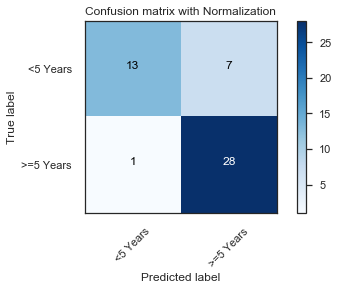

In [113]:
check_scores(df_2012_cleaned)

In [114]:
TP = 28
TN = 13
FP = 7
FN = 1

In [115]:
Accuracy = (TP+TN)/(TP+TN+FP+FN)
Precision = (TP/ float(TP+FP))
Recall = (TP/ float(TP+FN))
F1 = 2*Precision*Recall / (Precision+Recall)

print('Accuracy Score',Accuracy)
print('Precision Score',Precision)
print('Recall Score',Recall)
print('F1 Score',F1)

Accuracy Score 0.8367346938775511
Precision Score 0.8
Recall Score 0.9655172413793104
F1 Score 0.8750000000000001


After testing our model on the 2012 NBA draft class, we found that our model didn't perform as well as it did on our original data set. But the model still does a very good job at predicting both our positive and negative classes.